In [9]:
import matplotlib.pyplot as plt
import time
import pickle
import scipy.stats
from scipy import interpolate
from copy import copy
import pandas as pd
from matplotlib.animation import FuncAnimation
from scipy.stats import rv_continuous
from tqdm import tqdm
from itertools import permutations

import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib
import itertools



plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)
plt.rcParams['text.latex.preamble']=r'\usepackage{amsmath,amssymb,physics,bm}'

In [128]:
from importlib import reload

import GTN
reload(GTN)
from GTN import *

# Test

In [ ]:
Hi guys, I create a minimal model in 1+1d class A circuit to test the proof of principle. I find the idea using the second layer as a "bath" can work, which can steer the top layer to the lower band ground state of the SSH chain model where intra-unit-cell coupling =0 but the inter-unit-cell coupling =1.
The ultimate goal is to fill the lower band and empty the upper band in the top layer chain.

Below is the `pseudocode` that I design:
1. Measure each "inter-unit-cell" complex fermion pairs on the top layer. There could be four different outcomes:
    1.a Outcome is "c_B^dag-c_A^dag", denoted as |->; this is the desired mode (lower band), and will be always fixed by the same projector, so nothing is needed, and continue to the next pair of sites.
    1.b Outcome is "c_B^dag+c_A^dag", denoted as |+>; this is the undesired mode (upper band). So we directly flip the mode from upper band to the lower band within the top layer, by |-><+|.
    1.c Outcome is vacuum, denoted as |00>; Fill the lower band in top layer from bottom layer. See 2 for details.
    1.d Outcome is full, denoted as |11>; Deplete the upper band in top layer to bottom layer. See 3 for details.

2. To fill the lower band in top layer, we first measure the charge in mirror site (i.e. same site index) at sublatice B in bottom layer.
    2.a Outcome is 0. Then continue to measure the mirror site at sublattice A in the bottom layer.
        2.a.i Outcome is 0. Fixed fails. Continue to the next site.
        2.a.ii Outcome is 1. Transfer one mode from sublattice A in bottom layer to fill |-> in top layer.
    2.b Outcome is 1. Transfer one mode from sublattice B in bottom layer to fill |-> in top layer.

3. To deplete the upper band in top layer, we first measure the charge in mirror site (i.e. same site index) at sublatice A in bottom layer.
    3.a Outcome is 0. Transfer one mode from |+> in top layer to sublattice A in bottom layer.
    3.b Outcome is 1. Then continue to measure the mirror site at sublattice B in the bottom layer.
      3.b.i Outcome is 0. Transfer one mode from |+> in top layer to sublattice B in bottom layer.
      3.b.ii Outcome is 1. Fix fails. Continue to the next site.

4. After sweep the entire top layer chain. We randomize the bottom layer chain by applying exp(i θ γi γj), where i, and j are NN Majorana sites. This is to ensure that it will not stuck at 2.a.i that nothing to suck from the bottom layer, or 3.b.ii that nothing to dump to the bottom layer.

5. Go to 1, and repeat until target state is reached.



I create an animation to demonstrate this dynamics, which is also a typical actual trajectory. The "top" layer is complex fermion sites from 0 to 7, and the "bottom" complex fermion sites is from 8 to 15. The false color is showing the covariance matrix in the Majorana basis. The operation at each step is shown on the top.

With this exercise, now I have a solid understanding of how to use feedback to steer the dynamics to the target state. 
The only thing for 2+1d class AIII is to find a good real-space localized mode to measure. 


I also have two comments here:
1. I feel that this is like the absorbing state transition, instead of targeting a topological class, we directly target a specific state. This is different from what the previous paper did, as essentially, we don't include any "disorder" here-- it is a pristine system.  
2. This measurement with feedback can be done without postselection (previously we need postselection in 1+1d class A). Here, the state ensemble is only preserved when it reaches and stay in the target state; In the mid-circuit, the symmetry is actually not always there (namely, we can sometime fall into measurement outcome that does not respect symmetry)

In [ ]:
namely, there is no disorder. 

In [129]:
gtn=GTN(L=16,seed=3,op=False,random_init=True)


In [130]:
def measure_feedback_layer():
    for i in range(1,gtn.L//2,2):
        # print([i,(i+1)%(gtn.L//2)])
        gtn.measure_feedback_AIII([i,(i+1)%(gtn.L//2)],feedback=True)

In [131]:

def randomize():
    for i in range(gtn.L,2*gtn.L):
        print([i, (i+1)%(2*gtn.L)])
        gtn.randomize([i, (i+1)%(2*gtn.L)])


In [132]:
measure_feedback_layer()
randomize()
measure_feedback_layer()

[18, 19] [20, 21]
[22, 23] [24, 25]
[26, 27] [28, 29]
[30, 31] [16, 17]
[16, 17]
[17, 18]
[18, 19]
[19, 20]
[20, 21]
[21, 22]
[22, 23]
[23, 24]
[24, 25]
[25, 26]
[26, 27]
[27, 28]
[28, 29]
[29, 30]
[30, 31]
[31, 0]
[18, 19] [20, 21]
[22, 23] [24, 25]
[26, 27] [28, 29]
[30, 31] [16, 17]


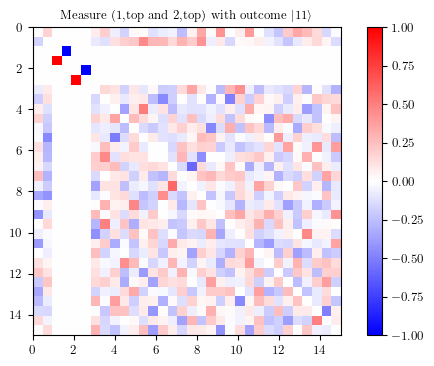

In [232]:
fig,ax=plt.subplots()
i=1
im=ax.imshow(gtn.C_m_history[i],cmap='bwr',vmin=-1,vmax=1,extent=[0,gtn.L-1,gtn.L-1,0])
plt.colorbar(im)
if i>0:
    ax.set_title(parse_text(gtn.n_history[i-1], gtn.i_history[i-1]))
else:
    ax.set_title('Random initial state')

## Create animation

In [233]:
import matplotlib.animation as animation

In [234]:
def update(frame):
    im.set_data(gtn.C_m_history[frame])
    if frame > 0:
        ax.set_title(parse_text(gtn.n_history[frame-1], gtn.i_history[frame-1]))
    else:
        ax.set_title('Random initial state')
    return im, ax

In [235]:
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=range(35),  # Generate frames from 0 to 40
    blit=False    # Blit optimizes the rendering
)

In [236]:
ani.save('animation.mp4', writer='ffmpeg', fps=1,dpi=200)

In [186]:
def parse_text(n_history,i_history):
    if len(i_history) ==4 and len(n_history)==4 and len(n_history[-1])==2:
        return parse_top(n_history,i_history)
    if len(i_history) ==2 and len(n_history)==3 and np.abs(n_history[0])==1:
        return parse_bottom(n_history,i_history)
    if len(i_history) ==6 and len(n_history)==2 and n_history[1] is None:
        return parse_top_to_bottom(n_history,i_history)
    if len(i_history) ==6 and len(n_history)==2 and n_history[0] is None:
        return parse_bottom_to_top(n_history,i_history)
    if len(i_history) ==4 and len(n_history)==2 and (n_history[0] is not None) and (n_history[1] is not None):
        return parse_top_flip(n_history,i_history)
    if len(i_history) ==2 and len(n_history)==3 and np.abs(n_history[0])<1:
        return parse_randominze(n_history,i_history)


In [94]:
len(gtn.n_history[2])

1

In [185]:
gtn.n_history[32], gtn.i_history[32]

([None, '-t'], [10, 11, 12, 13, 28, 29])

In [192]:
def parse_top(n_history,i_history):
    kind = n_history[-1]
    idx = i_history
    outcome={(-1,-1):'00',(-1,1):'-',(1,-1):'+',(1,1):'11'}
    return f'Measure ({idx[0]//2},top and {idx[2]//2},top) with outcome $|{outcome[kind]}\\rangle$'

def parse_bottom(n_history,i_history):
    kind = n_history[0]
    outcome = {1:1,-1:0}
    idx=(i_history[0]-gtn.L)//2
    return f'Measure ({idx},bottom) with outcome $|{outcome[kind]}\\rangle$'
def parse_randominze(n_history,i_history):
    idx=[(i-gtn.L)%gtn.L for i in i_history]
    if i_history[0]%2==0:
        return f'Random unitary on ($\gamma_{idx[0]//2}$,bottom) and ($\\bar{{\gamma}}_{idx[1]//2}$,bottom)'
    else:
        return f'Random unitary on ($\\bar{{\gamma}}_{idx[0]//2}$,bottom) and ($\gamma_{idx[1]//2}$,bottom)'

def parse_top_flip(n_history,i_history):
    source=[i_history[0]//2,i_history[2]//2]
    return f'Flip from ({source[0]},top + {source[1]},top) to ({source[0]},top - {source[1]},top)'
def parse_top_to_bottom(n_history,i_history):
    target=(i_history[-2]-gtn.L)//2
    source=[i_history[0]//2,i_history[2]//2]

    return f'Deplete mode ({source[0]},top + {source[1]},top) to ({target},bottom) '

def parse_bottom_to_top(n_history,i_history):
    source=(i_history[-2]-gtn.L)//2
    target=[i_history[0]//2,i_history[2]//2]
    return f'Fill mode ({target[0]},top - {target[1]},top) from ({source},bottom) '


In [193]:
# parse_top(gtn.n_history[0], gtn.i_history[0])
(parse_text(gtn.n_history[32], gtn.i_history[32]))

'Fill mode (5,top - 6,top) from (6,bottom) '

In [ ]:
'Transfer '

In [177]:
len(gtn.i_history)

8

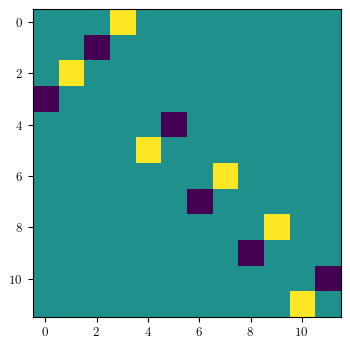

In [139]:
# plt.imshow(op_state_transfer(source=None,target='-t'))
plt.imshow(op_state_transfer(source='+t',target=None))

In [131]:
gtn.state_transfer([12,13,14,15],source='+t',target='-t')

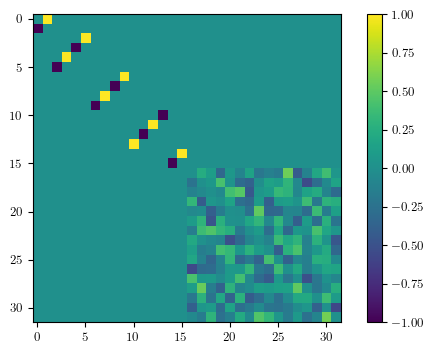

In [125]:
plt.imshow(gtn.C_m)
plt.colorbar()

In [60]:
gtn.measure_charge(legs=[0,1])

1.0

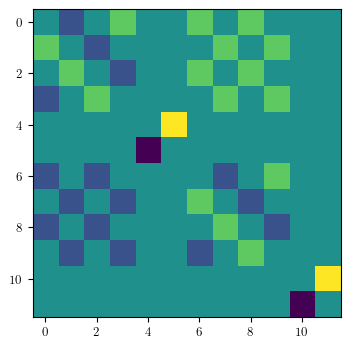

In [197]:
plt.imshow(op_state_transfer(target='-t',source=None))

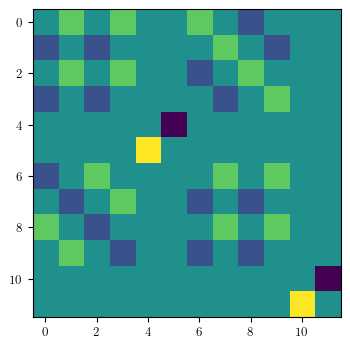

In [196]:
plt.imshow(op_state_transfer(source='+t',target=None))